# Get data

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
import math
import urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import cv2

dataDir = "/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
# dataFiles=['female_1.mat']

data = [] #processed and normalised with pose_idx
e = 2.718281828459045

def normalize_arr(arr,i):
    signal = arr.copy()
    signal = e**signal
    signal /= np.sum(signal)
    signal = np.clip(signal,1e-7,1e+7)
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    label = list((np.array(chn1).T)[-1].T.astype(int))

    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))
    # print(np.array(chn1).shape)
    print(label)
    # print('label[i]: ',label[i])
    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label[5]]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data




for file in dataFiles:
    data_path = dataDir+file
    print(data_path)
    mat = scipy.io.loadmat(data_path)
    mat.pop("__header__")
    mat.pop("__version__")
    mat.pop("__globals__")
    i=0
    for channel in mat: 
        if(i%2==0):
            channel2 =  channel[:-1]
            channel2 += '2'
            sigs1 = mat[channel] 
            sigs2 = mat[channel2]
            sigs1_norm = []
            sigs2_norm = []

            for signal in sigs1:
                signal = normalize_arr(signal,i)
                sigs1_norm.append(signal)
            for signal in sigs2:
                signal = normalize_arr(signal,i)
                sigs2_norm.append(signal)

            if i==0:
                data = get_channel_pair(sigs1_norm,sigs2_norm,i)
                # print(data)
            else:
                None
                data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                data += data_lc
                # data = data_lc
        i+=1
print(np.array(data).shape)
print(data[-3])






/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/female_1.mat
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/female_2.mat
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[3, 3, 3, 3, 3, 3, 

In [43]:
import pandas as pd
import math  
def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    time = 0
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n
        time += 1

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        row =np.pad(row,(0,n-n_len),'constant')
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)

# print(df)
dataset = data.copy()
df = pd.DataFrame(dataset, columns = ['channel1','channel2','label'])
mask = np.random.rand(len(df)) < 0.8
dataset_t_v = df[mask] #test & val
dataset_test = df[~mask]

val_test_mask = np.random.rand(len(dataset_t_v)) < 0.5
dataset_train = dataset_t_v[val_test_mask]
dataset_val = dataset_t_v[~val_test_mask]
# n=392

n=1458
dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)
print(dataset_train_ar[-20:][-1])

np.random.shuffle(dataset_train_ar)
np.random.shuffle(dataset_test_ar)
np.random.shuffle(dataset_val_ar)

print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)


X_val = split_X(dataset_train_ar)
y_val = split_y(dataset_train_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
X = reshape_arr(X)
X_val = reshape_arr(X_val)
X_test = reshape_arr(X_test)

# OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)

[3.39410495e-04 2.76772889e-04 3.57170505e-04 ... 3.18441122e-04
 4.10967689e-04 5.00000000e+00]
[3.23066614e-04 5.80794234e-04 3.57760775e-04 ... 4.60023181e-04
 3.32474769e-05 4.00000000e+00]


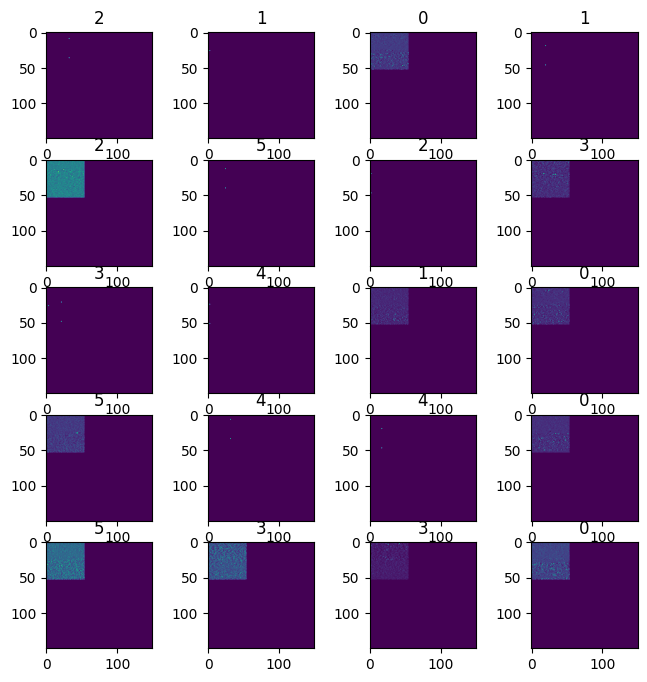

[2 1 0 1 2 5 2 3 3 4 1 0 5 4 4 0 5 3 3 0]


In [44]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X_tl[i-1])
plt.show()
print(y[:(columns*rows)])

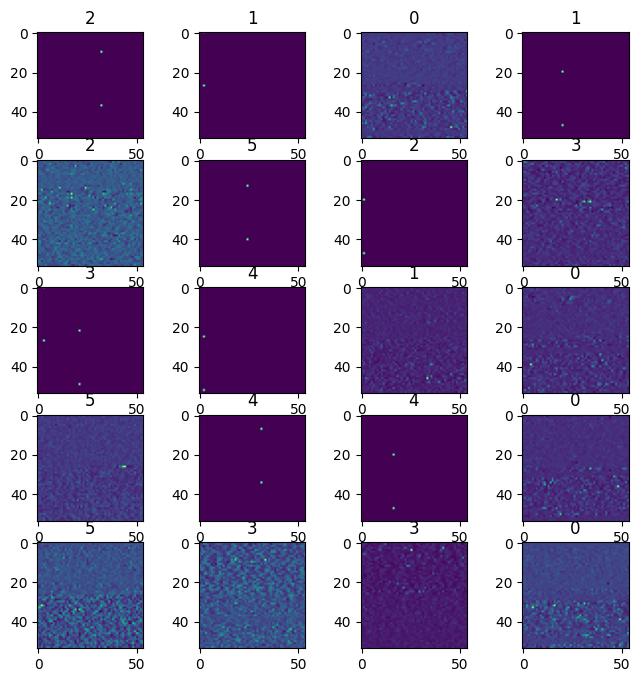

[2 1 0 1 2 5 2 3 3 4 1 0 5 4 4 0 5 3 3 0]


In [45]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X[i-1])
plt.show()
print(y[:(columns*rows)])

In [26]:
dataset_train

,channel1,channel2,label
0,0.000291,0.000320,0
1,0.000348,0.000304,0
6,0.000348,0.000275,0
9,0.000306,0.000320,0
11,0.000306,0.000337,0
...,...,...,...
539989,0.000363,0.000422,5
539994,0.000363,0.000344,5
539997,0.000296,0.000295,5
539998,0.000424,0.000381,5


# Transfer Learning
- RESNET50

OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)

In [46]:
print(X[0].shape)
rgb_batch_ts =  np.repeat(X[0][..., np.newaxis], 3, -1)
rgb_batch_ts.shape

(54, 54)


(54, 54, 3)

In [47]:
def signal_to_3channelimg(arr):
    print(arr[0].shape)
    rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
    rgb_batch_ts.shape
    return rgb_batch_ts

In [48]:
X_tl = signal_to_3channelimg(X_tl)
X_val_tl = signal_to_3channelimg(X_val_tl)
X_test_tl = signal_to_3channelimg(X_test_tl)

(150, 150)
(150, 150)
(150, 150)


In [49]:
#create basemodel and get it pre-trained para
base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(150,150,3),
    include_top=False
    )
base_model.trainable = False    

In [50]:
inputs = keras.Input(shape=(150, 150, 3))


# x = layers.Rescaling(2)(inputs)
# x = layers.Flatten()(x)
x = base_model(inputs, training=False)

# Apply some convolution and pooling layers
# x = layers.Flatten()(inputs)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

x = keras.layers.GlobalAveragePooling2D()(x)

num_classes = 6

# outputs = layers.Dense(num_classes, activation="softmax")(x)

x = layers.Dense(num_classes, activation="softmax")(x)
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(6)(x)  # Regularize with dropout
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 dense_8 (Dense)             (None, 5, 5, 128)         262272    
                                                                 
 dense_9 (Dense)             (None, 5, 5, 128)         16512     
                                                                 
 global_average_pooling2d_2  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                           

In [51]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

epochs = 20
batch_size = 64
history_tl = model.fit(X_tl, y,batch_size=batch_size, epochs=epochs)


Epoch 1/20
3/3 [==============================] - 7s 1s/step - loss: 7.1330
Epoch 2/20
3/3 [==============================] - 5s 1s/step - loss: 6.9672
Epoch 3/20
3/3 [==============================] - 4s 934ms/step - loss: 6.6115
Epoch 4/20
3/3 [==============================] - 3s 993ms/step - loss: 6.3676
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 6.1839
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 6.0179
Epoch 7/20
3/3 [==============================] - 4s 980ms/step - loss: 6.3343
Epoch 8/20
3/3 [==============================] - 3s 1s/step - loss: 6.3216
Epoch 9/20
3/3 [==============================] - 4s 1s/step - loss: 6.0710
Epoch 10/20
3/3 [==============================] - 3s 892ms/step - loss: 6.2293
Epoch 11/20
3/3 [==============================] - 3s 904ms/step - loss: 6.7306
Epoch 12/20
3/3 [==============================] - 3s 904ms/step - loss: 5.5704
Epoch 13/20
3/3 [==============================] - 4s 977ms/step - 

## visualise training history

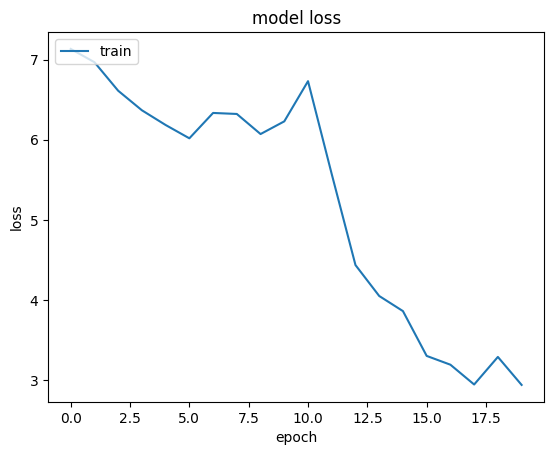

In [52]:

# summarize history for loss
plt.plot(history_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
model.evaluate(X_test_tl,y_test)

3/3 [==============================] - 3s 521ms/step - loss: 1.9857


1.9857044219970703

## save model ?

In [54]:
# model.save("./models/model2.keras")

# ALGO
## Random Forest

In [36]:
import math
import urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf


In [37]:
dataset_train

,channel1,channel2,label
0,0.000291,0.000320,0
1,0.000348,0.000304,0
6,0.000348,0.000275,0
9,0.000306,0.000320,0
11,0.000306,0.000337,0
...,...,...,...
539989,0.000363,0.000422,5
539994,0.000363,0.000344,5
539997,0.000296,0.000295,5
539998,0.000424,0.000381,5


In [38]:
print(dataset_test_ar[0][-1])
column_name =np.array(list(range(n*2+1)))
column_name=column_name+1
column_name=column_name.astype('str')
column_name
us = pd.DataFrame(dataset_test_ar,columns=column_name)

3.0


In [39]:
us

,1,2,3,4,5,6,7,8,9,10,...,776,777,778,779,780,781,782,783,784,785
0,0.000364,0.000073,0.000724,0.000983,0.000393,0.000087,0.000183,0.000469,0.000268,0.000304,...,0.000335,0.000433,0.000401,0.000182,0.000229,0.000685,0.000260,0.000241,0.000433,3.0
1,0.000446,0.000261,0.000354,0.000637,0.000230,0.000337,0.000183,0.000469,0.000413,0.000296,...,0.000422,0.000311,0.000344,0.000381,0.000267,0.000371,0.000635,0.000260,0.000381,3.0
2,0.000443,0.000411,0.000287,0.000352,0.000352,0.000371,0.000362,0.000318,0.000344,0.000326,...,0.000344,0.000318,0.000288,0.000401,0.000318,0.000327,0.000587,0.000362,0.000353,5.0
3,0.000512,0.000407,0.000215,0.000487,0.000418,0.000251,0.000221,0.000194,0.000251,0.000644,...,0.000207,0.000196,0.000371,0.000223,0.000260,0.000327,0.000319,0.000335,0.000281,3.0
4,0.000278,0.000462,0.000292,0.000315,0.000264,0.000341,0.000418,0.000324,0.000307,0.000324,...,0.000706,0.000134,0.000248,0.000248,0.000312,0.000242,0.000261,0.000364,0.000575,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0.000431,0.000240,0.000420,0.000420,0.000201,0.000516,0.000234,0.000287,0.000148,0.000228,...,0.000311,0.000260,0.000241,0.000335,0.000344,0.000353,0.000391,0.000456,0.000353,3.0
271,0.000417,0.000357,0.000331,0.000357,0.000367,0.000417,0.000376,0.000323,0.000340,0.000348,...,0.000161,0.000202,0.000345,0.000354,0.000275,0.000275,0.000383,0.000275,0.000275,0.0
272,0.000274,0.000254,0.000267,0.000412,0.000480,0.000254,0.000156,0.000604,0.000402,0.000288,...,0.000237,0.000484,0.000330,0.000225,0.000068,0.000405,0.000085,0.000018,0.000322,4.0
273,0.000365,0.000283,0.000405,0.000306,0.000306,0.000269,0.000314,0.000298,0.000276,0.000298,...,0.000174,0.000306,0.000322,0.000313,0.000484,0.000188,0.000262,0.000394,0.000203,1.0


In [40]:
# # Train a Gradient Boosted Trees model.
# model = tfdf.keras.GradientBoostedTreesModel(num_trees=1500)
lbel_index = n*n
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(us,label=str(n*2+1))

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model.
model_1.fit(train_ds)


Use 12 thread(s) for training
Use /tmp/tmpk1bv03bs as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'1': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, '2': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, '3': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, '4': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, '5': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, '6': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, '7': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, '8': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, '9': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, '10': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, '11': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, '12': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, '13': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, '14': <tf.Tensor 'data_13:0' shape=(None,) dtype=float64>, '15': <tf.Tensor 'data_14:0' shape=(None,) dtyp

[INFO 23-10-19 12:09:00.4328 +07 kernel.cc:773] Start Yggdrasil model training
[INFO 23-10-19 12:09:00.4328 +07 kernel.cc:774] Collect training examples
[INFO 23-10-19 12:09:00.4329 +07 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-10-19 12:09:00.7805 +07 kernel.cc:393] Number of batches: 1
[INFO 23-10-19 12:09:00.7805 +07 kernel.cc:394] Number of examples: 275
[INFO 23-10-19 12:09:00.7888 +07 kernel.cc:794] Training dataset:
Number of records: 275
Number of columns: 785

Number of columns by type:
	NUMERICAL: 784 (99.8726%)
	CATEGORICAL: 1 (0.127389%)

Columns:

NUMERICAL: 784 (99.8726%)
	0: "1" NUMERICAL mean:0.000331184 min:4.42456e-05 max

Model trained in 0:00:01.492095
Compiling model...
Model compiled.


In [41]:
model_1.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (784):
	1
	10
	100
	101
	102
	103
	104
	105
	106
	107
	108
	109
	11
	110
	111
	112
	113
	114
	115
	116
	117
	118
	119
	12
	120
	121
	122
	123
	124
	125
	126
	127
	128
	129
	13
	130
	131
	132
	133
	134
	135
	136
	137
	138
	139
	14
	140
	141
	142
	143
	144
	145
	146
	147
	148
	149
	15
	150
	151
	152
	153
	154
	155
	156
	157
	158
	159
	16
	160
	161
	162
	163
	164
	165
	166
	167
	168
	169
	17
	170
	171
	172
	173
	174
	175
	176
	177
	178
	179
	18
	180
	181
	182
	183
	184
	185
	186
	187
	188
	189
	19
	190
	191
	192
	193
	194
	195
	196
	197
	198
	199
	2
	20
	200
	201
	202
	203
	204
	205
	206
	207
	2

# Bluetooth <placeholder>

In [42]:
import bluetooth

nearby_devices = bluetooth.discover_devices(lookup_names=True)
print("Found {} devices.".format(len(nearby_devices)))

for addr, name in nearby_devices:
    print("  {} - {}".format(addr, name))

Found 0 devices.
